## Key indicators as leading and lagging predictors
The first of these algorithms is a general exploration into how certain key variables perform for stock market movements as leading and lagging predictors across various time series. These indicators include:
- The The Volatility Index (VIX)
- Index moving averages (50, 100 and 200 days)
- Treasury rates (5, 10, 30)
- Relative Strength Index
- Put/Call Ratio

In [35]:
#import all libraries needed for analysis and investment metadata
import yfinance as yf
import pandas_datareader as pdr
import alpha_vantage as av
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import visuals as vs

%matplotlib inline

In [55]:
#define api key and timeseries for using alpha_vantage
api_key = 'ALUI1VJSESQR07TD'
ts = TimeSeries(key=api_key)
symbols=['QQQ', 'VXX']

#date range for filtered_date
start = '2009-01-30'
end = datetime.now().strftime('%Y-%m-%d')

df = pd.DataFrame()

#pull in daily prices for each symbol
for sym in symbols:
    data, meta_data = ts.get_daily(symbol=sym, outputsize='full')
    
    # Filter data for the specified date range
    filtered_data = {date: values['4. close'] for date, values in data.items() if start <= date <= end}
    
    # Convert filtered_data into a DataFrame
    sym_df = pd.DataFrame.from_dict(filtered_data, orient='index')
    sym_df.index = pd.to_datetime(sym_df.index)
    
    # Rename the column to use the symbol as the column header
    sym_df = sym_df.rename(columns={0: sym})
    
    # Concatenate the DataFrame for the current symbol to the main DataFrame
    df = pd.concat([df, sym_df], axis=1)

df.head(5)

,QQQ,VXX
2023-10-04,359.75,24.28
2023-10-03,354.92,25.56
2023-10-02,361.26,23.36
2023-09-29,358.27,23.32
2023-09-28,358.01,22.87


In [56]:
#calculate moving averages
sma = [50, 100, 200]

df_sma = df.sort_index(ascending=True) #make ascending to calc SMAs

#at each sma value, calculate the corresponding sma for each ticker
for num in sma:
    for sym in symbols:
        col_name = f'{sym}_SMA_{num}' #pass through column name for each sma
        df_sma[col_name] = df_sma[sym].rolling(window=num).mean()

df_sma = df_sma.sort_index(ascending=False)

#cut the number of rows equal to the highest sma value to have a full working set of data
df_sma.head(10)

,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200
2023-10-04,359.75,24.28,368.7454,23.2287,363.8863,26.06055,331.40690,26.683975
2023-10-03,354.92,25.56,369.1260,23.2089,363.5508,26.19245,330.99260,26.637375
2023-10-02,361.26,23.36,369.5522,23.1637,363.2530,26.31525,330.65055,26.579975
2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075
2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525
2023-09-27,355.04,23.97,370.7622,23.2045,362.1598,26.77865,329.54420,26.457675
2023-09-26,354.21,25.04,371.3762,23.1947,361.7711,26.95955,329.18825,26.412725
2023-09-25,359.61,22.90,371.9442,23.1713,361.4019,27.11015,328.81985,26.363975
2023-09-22,357.91,22.87,372.3334,23.1917,360.9996,27.27005,328.43020,26.324825
2023-09-21,357.86,22.81,372.7582,23.2185,360.6424,27.41375,328.07885,26.283625


In [57]:
#remove rows with NaN
df_sma_clean = df_sma.dropna()
df_sma_clean = df_sma_clean.reset_index()
df_sma_clean = df_sma_clean.rename(columns={'index': 'date'})
df_sma_clean['date'] = pd.to_datetime(df_sma_clean['date'])
df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200
0,2023-10-04,359.75,24.28,368.7454,23.2287,363.8863,26.06055,331.40690,26.683975
1,2023-10-03,354.92,25.56,369.1260,23.2089,363.5508,26.19245,330.99260,26.637375
2,2023-10-02,361.26,23.36,369.5522,23.1637,363.2530,26.31525,330.65055,26.579975
3,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075
4,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525


In [67]:
#years to pull in historic treasury rates for
years = [2, 10, 30]

df_rate = pd.DataFrame()

#set up date column
url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=ALUI1VJSESQR07TD'
r = requests.get(url)
data = r.json()

for i in data['data']:
    df_rate = df_rate.append({'date': i['date']}, ignore_index=True)
    
#extract historic treasury rates reported daily
for year in years:
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity='+str(year)+'year&apikey=ALUI1VJSESQR07TD'
    r = requests.get(url)
    data = r.json()
    
    #populate rate
    for i in data['data']:
        df_rate.loc[df_rate['date'] == i['date'], str(year) +'yr_rate'] = i['value']
    
df_rate['date'] = pd.to_datetime(df_rate['date'])    
df_rate.head(10)

,date,2yr_rate,10yr_rate,30yr_rate
0,2023-10-03,5.15,4.81,4.95
1,2023-10-02,5.12,4.69,4.81
2,2023-09-29,5.03,4.59,4.73
3,2023-09-28,5.04,4.59,4.71
4,2023-09-27,5.10,4.61,4.73
5,2023-09-26,5.04,4.56,4.70
6,2023-09-25,5.09,4.55,4.67
7,2023-09-22,5.10,4.44,4.53
8,2023-09-21,5.12,4.49,4.56
9,2023-09-20,5.12,4.35,4.40


In [59]:
#Pull in Relative Strength Index
symbol = 'QQQ'

#set up date column
url = 'https://www.alphavantage.co/query?function=RSI&symbol='+symbol+'&interval=daily&time_period=10&series_type=open&apikey='+api_key
rsi_resp = requests.get(url)
rsi = json.loads(rsi_resp.content)

rsi_data = rsi['Technical Analysis: RSI']

df_rsi = pd.DataFrame([(date, rsi['RSI']) for date, rsi in rsi_data.items()], columns=['date', 'RSI'])
df_rsi['date'] = pd.to_datetime(df_rsi['date'])


df_rsi.head(25)

,date,RSI
0,2023-10-04,36.7015
1,2023-10-03,41.0101
2,2023-10-02,40.5089
3,2023-09-29,44.7898
4,2023-09-28,27.7772
5,2023-09-27,29.1595
6,2023-09-26,30.9147
7,2023-09-25,30.7749
8,2023-09-22,33.5214
9,2023-09-21,34.7301


## Further cleanup/data enhancements
### Categorical Field Additions
- Binary above or below SMAs
- General 30 day trend for rates (all)
- Flag for if rates are inverted
- 7 and 30 day trend for VXX

In [68]:
#above/below SMAs
df_sma_clean['QQQ'] = pd.to_numeric(df_sma_clean['QQQ'])
df_sma_clean['QQQ_SMA_50'] = pd.to_numeric(df_sma_clean['QQQ_SMA_50'])
df_sma_clean['QQQ_SMA_100'] = pd.to_numeric(df_sma_clean['QQQ_SMA_100'])
df_sma_clean['QQQ_SMA_200'] = pd.to_numeric(df_sma_clean['QQQ_SMA_200'])

df_sma_clean['Above_QQQ_SMA_50'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_50'] else 0, axis=1)
df_sma_clean['Above_QQQ_SMA_100'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_100'] else 0, axis=1)
df_sma_clean['Above_QQQ_SMA_200'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_200'] else 0, axis=1)

df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_mean,VXX_7_rising,VXX_30_mean,VXX_30_rising
0,2023-10-04,359.75,24.28,368.7454,23.2287,363.8863,26.06055,331.40690,26.683975,0,0,1,24.057143,1,22.413167,1
1,2023-10-03,354.92,25.56,369.1260,23.2089,363.5508,26.19245,330.99260,26.637375,0,0,1,23.860000,1,22.441833,1
2,2023-10-02,361.26,23.36,369.5522,23.1637,363.2530,26.31525,330.65055,26.579975,0,0,1,23.475714,0,22.424167,1
3,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075,0,0,1,23.397143,0,22.502500,1
4,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525,0,0,1,23.091429,0,22.604500,1


In [69]:
#vxx
df_sma_clean = df_sma_clean.sort_values(by='date', ascending=True)

#convert existing fields to numeric data
df_sma_clean['VXX'] = pd.to_numeric(df_sma_clean['VXX'])

#calc 7 day rolling mean and create new column
df_sma_clean['VXX_7_mean'] = df_sma_clean['VXX'].rolling(window=7).mean()
df_sma_clean['VXX_7_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_7_mean']).astype(int)

#calc 30 day rolling mean and create new column
df_sma_clean['VXX_30_mean'] = df_sma_clean['VXX'].rolling(window=30).mean()
df_sma_clean['VXX_30_rising'] = (df_sma_clean['VXX'] > df_sma_clean['VXX_30_mean']).astype(int)

#resort in descending order and print first few rows
df_sma_clean = df_sma_clean.sort_values(by='date', ascending=False)
df_sma_clean.head(5)

,date,QQQ,VXX,QQQ_SMA_50,VXX_SMA_50,QQQ_SMA_100,VXX_SMA_100,QQQ_SMA_200,VXX_SMA_200,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_mean,VXX_7_rising,VXX_30_mean,VXX_30_rising
0,2023-10-04,359.75,24.28,368.7454,23.2287,363.8863,26.06055,331.40690,26.683975,0,0,1,24.057143,1,22.413167,1
1,2023-10-03,354.92,25.56,369.1260,23.2089,363.5508,26.19245,330.99260,26.637375,0,0,1,23.860000,1,22.441833,1
2,2023-10-02,361.26,23.36,369.5522,23.1637,363.2530,26.31525,330.65055,26.579975,0,0,1,23.475714,0,22.424167,1
3,2023-09-29,358.27,23.32,369.8396,23.1705,362.8568,26.47195,330.28750,26.536075,0,0,1,23.397143,0,22.502500,1
4,2023-09-28,358.01,22.87,370.2094,23.1839,362.5110,26.61985,329.92405,26.495525,0,0,1,23.091429,0,22.604500,1


In [70]:
#determine if rates are falling or rising
df_rate_clean = df_rate

df_rate_clean = df_rate_clean.sort_values(by='date', ascending=True)

#convert all rates to float values
df_rate_clean['2yr_rate'] = pd.to_numeric(df_rate_clean['2yr_rate'], errors='coerce', downcast='float')
df_rate_clean['10yr_rate'] = pd.to_numeric(df_rate_clean['10yr_rate'], errors='coerce', downcast='float')
df_rate_clean['30yr_rate'] = pd.to_numeric(df_rate_clean['30yr_rate'], errors='coerce', downcast='float')

df_rate_clean['rate_sum'] = df_rate_clean['2yr_rate'] + df_rate_clean['10yr_rate'] + df_rate_clean['30yr_rate']

#remove NaN rows
df_rate_clean = df_rate_clean.dropna()

# calculate rolling means and add a column
df_rate_clean['rate_30_ave'] = df_rate_clean['rate_sum'].rolling(window=30).mean()
df_rate_clean['rates_rising'] = (df_rate_clean['rate_sum'] > df_rate_clean['rate_30_ave']).astype(int)

df_rate_clean = df_rate_clean.sort_values(by='date', ascending=False)

df_rate_clean.head(5)

,date,2yr_rate,10yr_rate,30yr_rate,rate_sum,rate_30_ave,rates_rising
0,2023-10-03,5.15,4.81,4.95,14.910000,13.812333,1
1,2023-10-02,5.12,4.69,4.81,14.619999,13.774000,1
2,2023-09-29,5.03,4.59,4.73,14.350000,13.738667,1
3,2023-09-28,5.04,4.59,4.71,14.340000,13.715333,1
4,2023-09-27,5.10,4.61,4.73,14.440001,13.691667,1


In [71]:
#rsi cleanup
df_rsi_clean = df_rsi.sort_values(by='date', ascending=True)

#convert existing fields to numeric data
df_rsi_clean['RSI'] = pd.to_numeric(df_rsi_clean['RSI'])

df_rsi_clean['RSI_2_mean'] = df_rsi_clean['RSI'].rolling(window=2).mean()
df_rsi_clean['RSI_2_Below'] = (df_rsi_clean['RSI_2_mean'] <= 35).astype(int) 

df_rsi_clean['RSI_5_mean'] = df_rsi_clean['RSI'].rolling(window=5).mean()
df_rsi_clean['RSI_5_Below'] = (df_rsi_clean['RSI_5_mean'] <= 35).astype(int)

df_rsi_clean = df_rsi_clean.sort_values(by='date', ascending=False)
df_rsi_clean.head(25)

,date,RSI,RSI_2_mean,RSI_2_Below,RSI_5_mean,RSI_5_Below
0,2023-10-04,36.7015,38.85580,0,38.15750,0
1,2023-10-03,41.0101,40.75950,0,36.64910,0
2,2023-10-02,40.5089,42.64935,0,34.63002,1
3,2023-09-29,44.7898,36.28350,0,32.68322,1
4,2023-09-28,27.7772,28.46835,1,30.42954,1
5,2023-09-27,29.1595,30.03710,1,31.82012,1
6,2023-09-26,30.9147,30.84480,1,35.65622,0
7,2023-09-25,30.7749,32.14815,1,38.52096,0
8,2023-09-22,33.5214,34.12575,1,41.41366,0
9,2023-09-21,34.7301,41.53505,0,45.74764,0


## Prepare DataFrames for Analysis
### Two separate tables
- Discrete variables (1s and 0s)
- Continuous variables
- Add columns for 1, 3, 5, 7, 15, 30, 60, 90 day performance

In [72]:
#create discrete and continuous tables
df_discrete = df_sma_clean[['date', 'QQQ', 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising']]
df_discrete = df_discrete.merge(df_rate_clean[['date', 'rates_rising']], on='date')
df_discrete = df_discrete.merge(df_rsi_clean[['date', 'RSI_2_Below', 'RSI_5_Below']], on='date')

df_continuous = df_sma_clean[['date', 'QQQ', 'QQQ_SMA_50', 'QQQ_SMA_100', 'QQQ_SMA_200', 'VXX_SMA_50', 'VXX_SMA_100', 'VXX_SMA_200']]
df_continuous = df_continuous.merge(df_rate_clean[['date', 'rate_sum']], on='date')
df_continuous = df_continuous.merge(df_rsi_clean[['date', 'RSI_2_mean', 'RSI_5_mean']], on='date')

In [75]:
#add columns to each new dataframe for performance over certain periods
periods = [1, 3, 5, 7, 15, 30, 60, 90]

#create new fields for discrete and continuous tables to show performance in future for each period
for period in periods:
    df_discrete[str(period)+'_day'] = (df_discrete['QQQ'].shift(period) > df_discrete['QQQ']).astype(int)
    df_continuous[str(period)+'_day'] = (df_continuous['QQQ'].shift(period)/df_discrete['QQQ'])
    

In [80]:
df_discrete[['QQQ','1_day','30_day', 'RSI_2_Below', 'RSI_5_Below']].head(50)

,QQQ,1_day,30_day,RSI_2_Below,RSI_5_Below
0,354.92,0,0,0,0
1,361.26,0,0,0,1
2,358.27,1,0,0,1
3,358.01,1,0,1,1
4,355.04,1,0,1,1
5,354.21,1,0,1,0
6,359.61,0,0,1,0
7,357.91,1,0,1,0
8,357.86,1,0,0,0
9,364.54,0,0,0,0


In [78]:
df_discrete.head(5)

,date,QQQ,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_rising,VXX_30_rising,rates_rising,RSI_2_Below,RSI_5_Below,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-10-03,354.92,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,2023-10-02,361.26,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0
2,2023-09-29,358.27,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0
3,2023-09-28,358.01,0,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0
4,2023-09-27,355.04,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0


In [97]:
df_continuous.head(5)

,date,QQQ,QQQ_SMA_50,QQQ_SMA_100,QQQ_SMA_200,VXX_SMA_50,VXX_SMA_100,VXX_SMA_200,rate_sum,RSI_7_mean,RSI_30_mean,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-09-28,358.01,370.2094,362.5110,329.92405,23.1839,26.61985,26.495525,14.340000,33.602543,45.805947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-27,355.04,370.7622,362.1598,329.54420,23.2045,26.77865,26.457675,14.440001,36.097000,46.118973,1.008365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09-26,354.21,371.3762,361.7711,329.18825,23.1947,26.95955,26.412725,14.300000,38.393986,46.566367,1.002343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-09-25,359.61,371.9442,361.4019,328.81985,23.1713,27.11015,26.363975,14.310000,41.862071,46.623820,0.984984,0.995551,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-09-22,357.91,372.3334,360.9996,328.43020,23.1917,27.27005,26.324825,14.070000,45.370814,46.710643,1.004750,0.991981,NaN,NaN,NaN,NaN,NaN,NaN


## Main Functions
Puts all of the above steps together for a seamless execution and returns the two cleaned data frames

In [157]:
def rates():

    #years to pull in historic treasury rates for
    years = [2, 10, 30]

    df_rate = pd.DataFrame()

    #set up date column
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=ALUI1VJSESQR07TD'
    r = requests.get(url)
    data = r.json()

    for i in data['data']:
        df_rate = df_rate.append({'date': i['date']}, ignore_index=True)

    #extract historic treasury rates reported daily
    for year in years:
        url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity='+str(year)+'year&apikey=ALUI1VJSESQR07TD'
        r = requests.get(url)
        data = r.json()

        #populate rate
        for i in data['data']:
            df_rate.loc[df_rate['date'] == i['date'], str(year) +'yr_rate'] = i['value']

    df_rate['date'] = pd.to_datetime(df_rate['date']) 
    
    return df_rate

In [158]:
def data_compilation(symbols):
    api_key = 'ALUI1VJSESQR07TD'
    ts = TimeSeries(key=api_key)
    #symbols=['QQQ', 'VXX']

    #date range for filtered_date
    start = '2009-01-30'
    end = datetime.now().strftime('%Y-%m-%d')

    df = pd.DataFrame()

    #pull in daily prices for each symbol
    for sym in symbols:
        data, meta_data = ts.get_daily(symbol=sym, outputsize='full')

        #filter data for the specified date range
        filtered_data = {date: values['4. close'] for date, values in data.items() if start <= date <= end}

        #convert filtered_data into a DF
        sym_df = pd.DataFrame.from_dict(filtered_data, orient='index')
        sym_df.index = pd.to_datetime(sym_df.index)

        #rename the column + use the symbol as the column header
        sym_df = sym_df.rename(columns={0: sym})

        #concatenate the DF for the current symbol to the main DF
        df = pd.concat([df, sym_df], axis=1)

    #calculate moving averages
    sma = [50, 100, 200]

    df_sma = df.sort_index(ascending=True) #make ascending to calc SMAs

    #at each sma value, calculate the corresponding sma for each ticker
    for num in sma:
        for sym in symbols:
            col_name = f'{sym}_SMA_{num}' #pass through column name for each sma
            df_sma[col_name] = df_sma[sym].rolling(window=num).mean()

    df_sma = df_sma.sort_index(ascending=False)
    
    #remove rows with NaN
    df_sma_clean = df_sma.dropna()
    df_sma_clean = df_sma_clean.reset_index()
    df_sma_clean = df_sma_clean.rename(columns={'index': 'date'})
    df_sma_clean['date'] = pd.to_datetime(df_sma_clean['date'])
    
    #run rates function
    df_rate = rates()
    
    #Pull in Relative Strength Index
    symbol = symbols[0]

    #set up date column
    url = 'https://www.alphavantage.co/query?function=RSI&symbol='+symbol+'&interval=daily&time_period=10&series_type=open&apikey='+api_key
    rsi_resp = requests.get(url)
    rsi = json.loads(rsi_resp.content)

    rsi_data = rsi['Technical Analysis: RSI']

    df_rsi = pd.DataFrame([(date, rsi['RSI']) for date, rsi in rsi_data.items()], columns=['date', 'RSI'])
    df_rsi['date'] = pd.to_datetime(df_rsi['date'])
    
    #above/below SMAs
    df_sma_clean['QQQ'] = pd.to_numeric(df_sma_clean['QQQ'])
    df_sma_clean['QQQ_SMA_50'] = pd.to_numeric(df_sma_clean['QQQ_SMA_50'])
    df_sma_clean['QQQ_SMA_100'] = pd.to_numeric(df_sma_clean['QQQ_SMA_100'])
    df_sma_clean['QQQ_SMA_200'] = pd.to_numeric(df_sma_clean['QQQ_SMA_200'])

    df_sma_clean['Above_QQQ_SMA_50'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_50'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_100'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_100'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_200'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_200'] else 0, axis=1)

    #vxx
    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_sma_clean['VXX'] = pd.to_numeric(df_sma_clean['VXX'])

    df_sma_clean['VXX_7_mean'] = df_sma_clean['VXX'].rolling(window=7).mean()
    df_sma_clean['VXX_7_rising'] = (df_sma_clean['VXX'] < df_sma_clean['VXX_7_mean']).astype(int)

    df_sma_clean['VXX_30_mean'] = df_sma_clean['VXX'].rolling(window=30).mean()
    df_sma_clean['VXX_30_rising'] = (df_sma_clean['VXX'] < df_sma_clean['VXX_30_mean']).astype(int)

    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=False)
    
    #determine if rates are falling or rising
    df_rate_clean = df_rate

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=True)

    df_rate_clean['2yr_rate'] = pd.to_numeric(df_rate_clean['2yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['10yr_rate'] = pd.to_numeric(df_rate_clean['10yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['30yr_rate'] = pd.to_numeric(df_rate_clean['30yr_rate'], errors='coerce', downcast='float')

    df_rate_clean['rate_sum'] = df_rate_clean['2yr_rate'] + df_rate_clean['10yr_rate'] + df_rate_clean['30yr_rate']

    df_rate_clean = df_rate_clean.dropna()

    df_rate_clean['rate_30_ave'] = df_rate_clean['rate_sum'].rolling(window=30).mean()
    df_rate_clean['rates_rising'] = (df_rate_clean['rate_sum'] > df_rate_clean['rate_30_ave']).astype(int)

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=False)
    df_rsi_clean = df_rsi.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_rsi_clean['RSI'] = pd.to_numeric(df_rsi_clean['RSI'])

    df_rsi_clean['RSI_7_mean'] = df_rsi_clean['RSI'].rolling(window=7).mean()
    df_rsi_clean['RSI_7_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_7_mean']).astype(int)

    df_rsi_clean['RSI_30_mean'] = df_rsi_clean['RSI'].rolling(window=30).mean()
    df_rsi_clean['RSI_30_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_30_mean']).astype(int)

    df_rsi_clean = df_rsi_clean.sort_values(by='date', ascending=False) 

    #create discrete and continuous tables
    df_discrete = df_sma_clean[['date', 'QQQ', 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising']]
    df_discrete = df_discrete.merge(df_rate_clean[['date', 'rates_rising']], on='date')
    df_discrete = df_discrete.merge(df_rsi_clean[['date', 'RSI_7_rising', 'RSI_30_rising']], on='date')

    df_continuous = df_sma_clean[['date', 'QQQ', 'QQQ_SMA_50', 'QQQ_SMA_100', 'QQQ_SMA_200', 'VXX_SMA_50', 'VXX_SMA_100', 'VXX_SMA_200']]
    df_continuous = df_continuous.merge(df_rate_clean[['date', 'rate_sum']], on='date')
    df_continuous = df_continuous.merge(df_rsi_clean[['date', 'RSI_7_mean', 'RSI_30_mean']], on='date')
    
    #add columns to each new dataframe for performance over certain periods
    periods = [1, 3, 5, 7, 15, 30, 60, 90]

    #create new fields for discrete and continuous tables to show performance in future for each period
    for period in periods:
        df_discrete[str(period)+'_day'] = (df_discrete['QQQ'].shift(period) > df_discrete['QQQ']).astype(int)
        df_continuous[str(period)+'_day'] = (df_continuous['QQQ'].shift(period)/df_discrete['QQQ'])
        
    return df_discrete, df_continuous

In [159]:
#change symbols you want to run analysis for
symbols=['QQQ', 'VXX']

#Run through data_compilation function and return a discrete and continous dataframe
df_discrete, df_continuous = data_compilation(symbols)

# Start Analysis
- Test predictability of each variable
- Narrow down to most explanatory 
- Develop ML model

In [160]:
df_discrete = df_discrete.rename(columns={'VXX_7_rising': 'VXX_7_falling'})
df_discrete = df_discrete.rename(columns={'VXX_30_rising': 'VXX_30_falling'})

df_discrete.head(5)

,date,QQQ,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_falling,VXX_30_falling,rates_rising,RSI_7_rising,RSI_30_rising,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-10-03,354.92,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
1,2023-10-02,361.26,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0
2,2023-09-29,358.27,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0
3,2023-09-28,358.01,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0
4,2023-09-27,355.04,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0


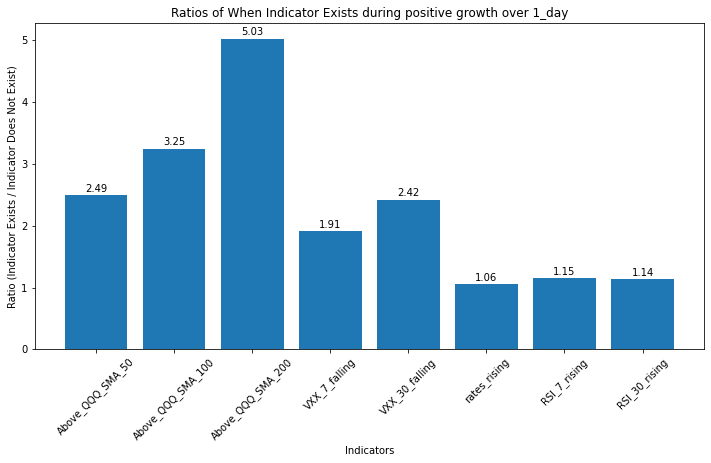

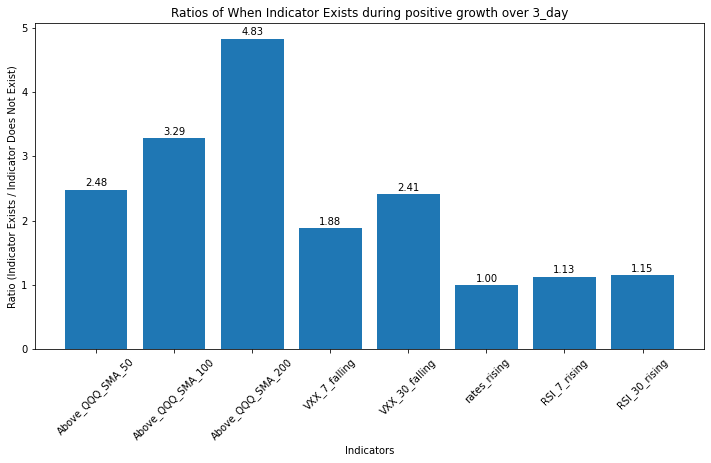

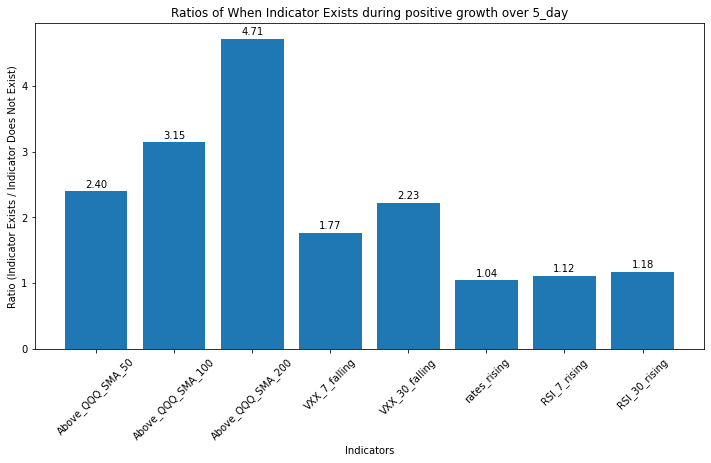

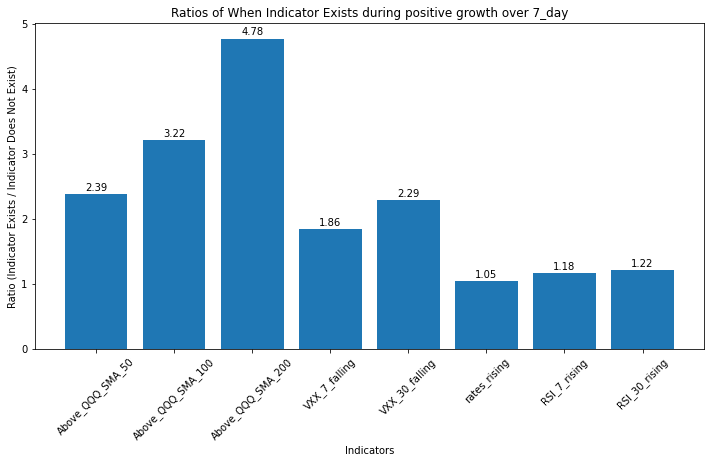

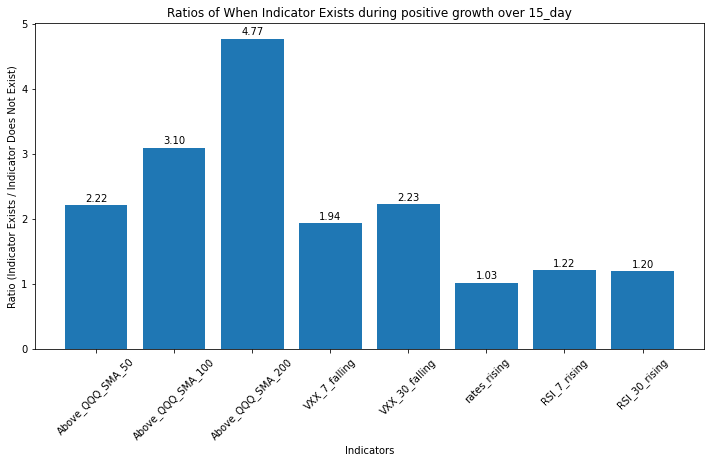

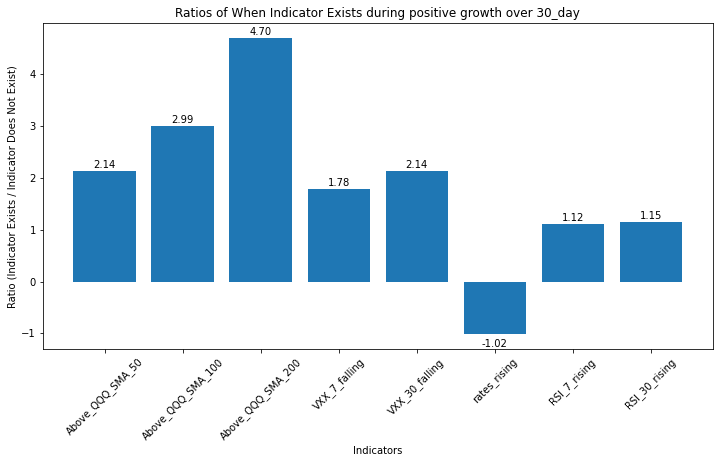

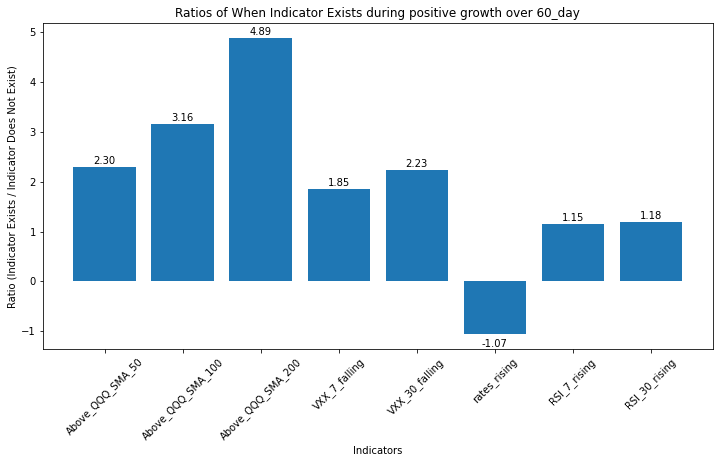

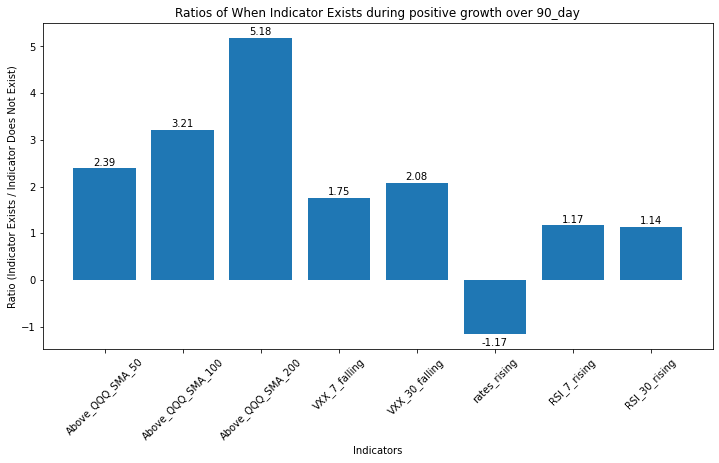

In [161]:
days = ['1_day', '3_day', '5_day', '7_day', '15_day', '30_day', '60_day', '90_day']

#indicators to test
independent_vars = ['Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_falling', 'VXX_30_falling', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']

#iterate through each 'day' time horizon
for day in days:
    #store the ratios in a dict
    ratio_dict = {}
    
    #calc the ratios for each independent variable
    for col in independent_vars:
        #calc the numerator (count when both col and day are 1)
        numerator = ((df_discrete[day] == 1) & (df_discrete[col] == 1)).sum()
        
        #calc the denominator (count when day is 1 and col is 0)
        denominator = ((df_discrete[day] == 1) & (df_discrete[col] == 0)).sum()
        
        #calc the ratio, handling division by zero and ratios below 1
        if denominator != 0:
            ratio = numerator / denominator
            if ratio < 1:
                ratio = -1 / ratio  #calc the negative reciprocal
        else:
            ratio = 0
        
        ratio_dict[col] = ratio

    #extract the values and labels for plotting
    values = list(ratio_dict.values())
    labels = list(ratio_dict.keys())
    
    #create graph, bars and points
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(labels, values)
    points = np.array(values)
    
    #standardize labelling depending on if value is positive or negative
    for label, point in zip(labels, points):
        if point >= 0:
            ax.text(label, point + 0.02, f'{point:.2f}', ha='center', va='bottom')
        else:
            ax.text(label, point - 0.08, f'{point:.2f}', ha='center', va='top')
    
    #finish setting up graph specifics
    ax.set_title(f'Ratios of When Indicator Exists during positive growth over {day}')
    ax.set_xlabel('Indicators')
    ax.set_ylabel('Ratio (Indicator Exists / Indicator Does Not Exist)')
    ax.set_xticks(labels) 
    ax.set_xticklabels(labels, rotation=45)
    
    #plot results
    plt.show()

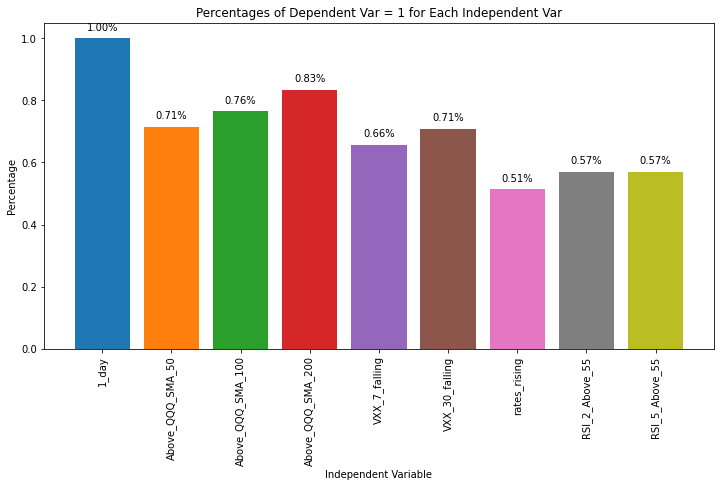

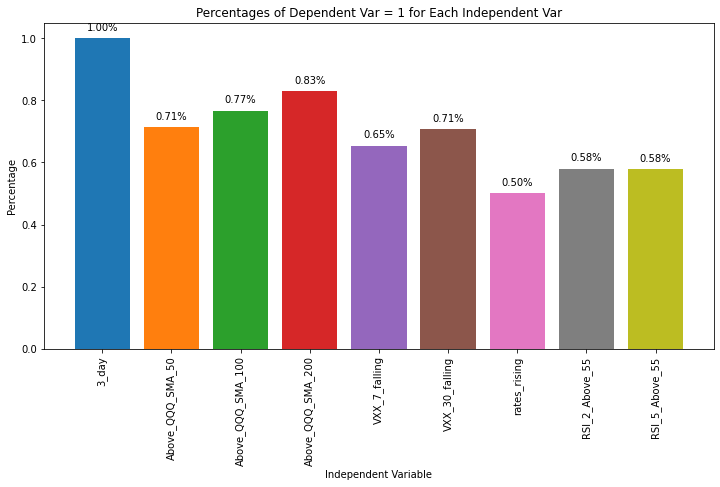

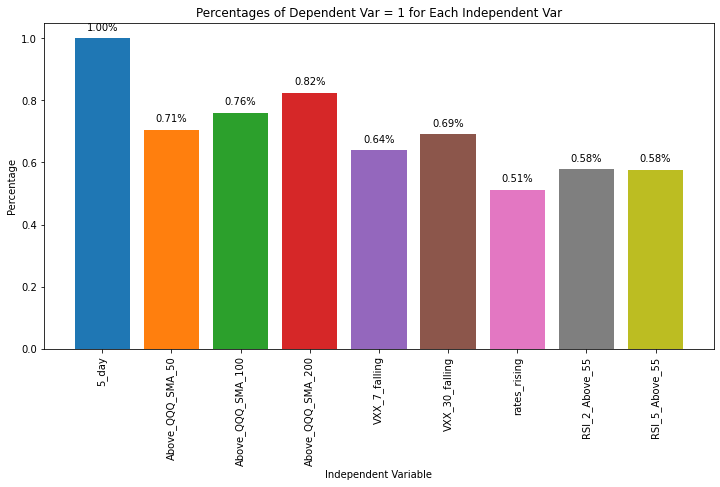

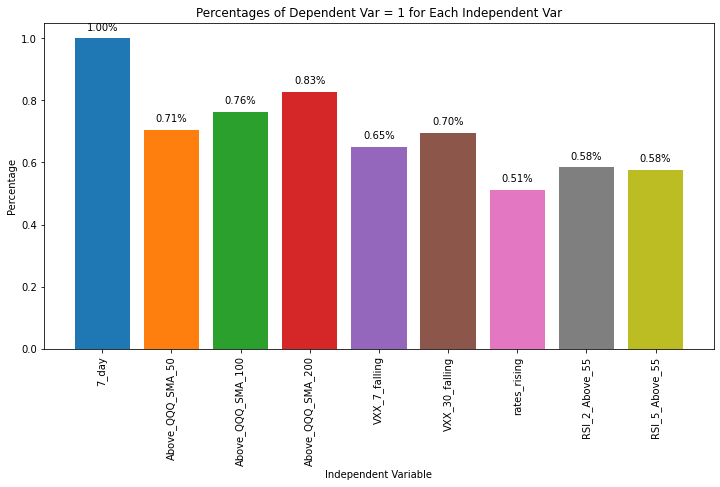

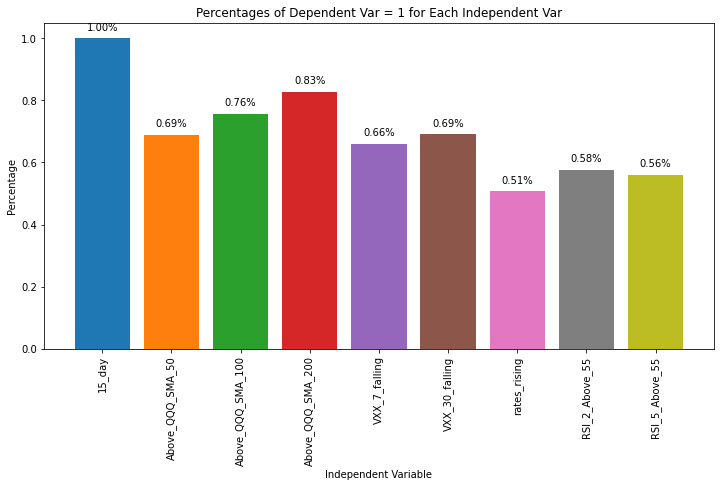

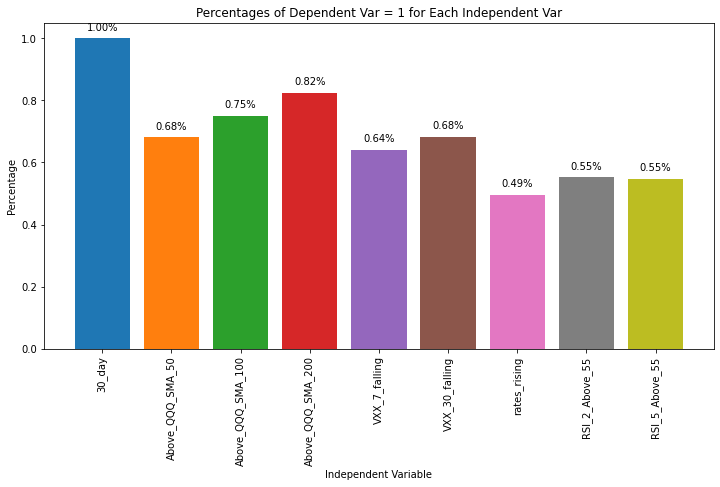

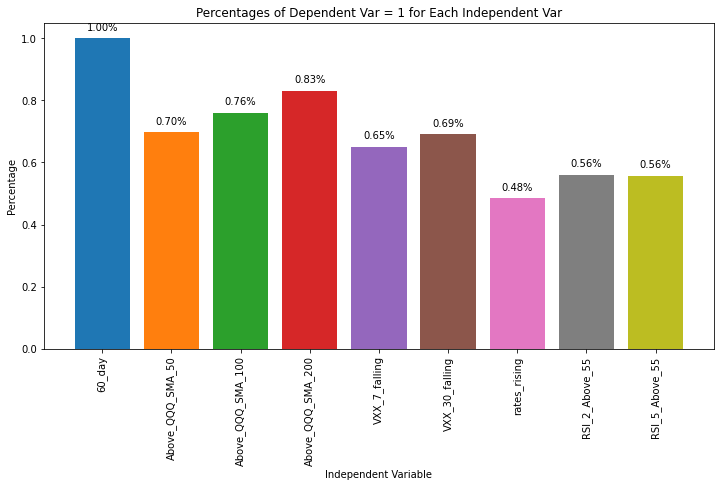

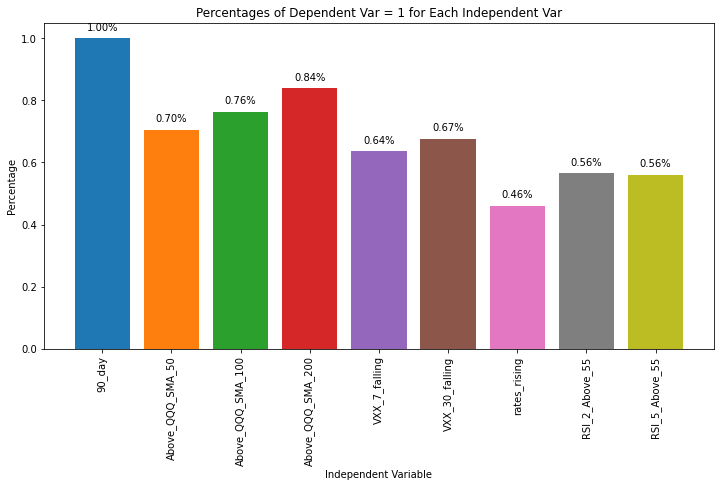

In [104]:
days = ['1_day', '3_day', '5_day', '7_day', '15_day', '30_day', '60_day', '90_day']

for day in days:

    # Create a list of independent variable column names
    independent_vars = [day, 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_falling', 'VXX_30_falling', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']

    # Create a dictionary to store the counts of dependent variable = 1 for each independent variable
    count_dict = {}
    for col in independent_vars:
        count_dict[col] = 0

    # Iterate through the dataframe and increment the count for each independent variable
    for index, row in df_discrete.iterrows():
        for col in independent_vars:
            if row[col] == 1 and row[day] == 1:
                count_dict[col] += 1

    # Create a dictionary to store the percentages of dependent variable = 1 for each independent variable
    percent_dict = {}
    for col, count in count_dict.items():
        percent_dict[col] = count / (df_discrete[day] == 1).sum()

    # Create a bar chart of the percentages
    plt.figure(figsize=(12, 6))
    for col, percent in percent_dict.items():
        plt.bar(col, percent)

        # Add label above each bar graph with the value of the percentage
        plt.text(col, percent + 0.02, f'{percent:.2f}%', ha='center', va='bottom')

    plt.title('Percentages of Dependent Var = 1 for Each Independent Var')
    plt.xlabel('Independent Variable')
    plt.ylabel('Percentage')
    plt.xticks(rotation=90)
    plt.show()

In [162]:
df_discrete['RSI_7_rising'].sum()

1864

# Machine Learning

In [163]:
price_change = pd.DataFrame()
price_change = df_discrete['30_day']
features = df_discrete[['Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_falling', 'VXX_30_falling', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']]

In [164]:
#split the data
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    price_change,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2776 samples.
Testing set has 694 samples.


In [165]:
#naive predictor performance
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = np.sum(price_change)/len(price_change)
recall = np.sum(price_change)/(np.sum(price_change) + 0)
precision = np.sum(price_change)/(np.sum(price_change) + (len(price_change) - np.sum(price_change)))
b = 0.5

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+(b**2))*((precision * recall)/((b**2*precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.6813, F-score: 0.7277]


In [166]:
#training and predicting pipelines
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size));
    
    # Return the results
    return results

print('Success')

Success


LogisticRegression trained on 2776 samples.
LogisticRegression trained on 277 samples.
LogisticRegression trained on 27 samples.
RandomForestClassifier trained on 2776 samples.
RandomForestClassifier trained on 277 samples.
RandomForestClassifier trained on 27 samples.
GradientBoostingClassifier trained on 2776 samples.
GradientBoostingClassifier trained on 277 samples.
GradientBoostingClassifier trained on 27 samples.


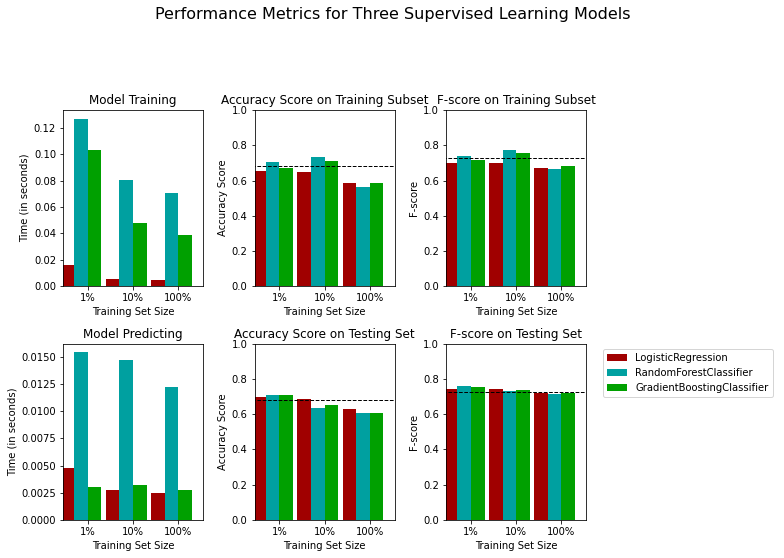

In [167]:
#initial model evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state = 0)
clf_B = RandomForestClassifier(random_state = 0)
clf_C = SVC(random_state = 0)
clf_D = clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100, samples_10, samples_1]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
vs.evaluate(results, accuracy, fscore);

# Top Model Optimization

In [168]:
#Random Forrest Training
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Adding 'None' for default behavior
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.7075
F-score on testing data: 0.7587

Optimized Model
------
Final accuracy score on the testing data: 0.7075
Final F-score on the testing data: 0.7552


In [33]:
#GradientBoostingClassifier Training
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'max_features': ['auto', 'sqrt', 'log2', None],  # Adding 'None' for default behavior
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3645 fits failed out of a total of 14580.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/si

Unoptimized model
------
Accuracy score on testing data: 0.7089
F-score on testing data: 0.7569

Optimized Model
------
Final accuracy score on the testing data: 0.7104
Final F-score on the testing data: 0.7579


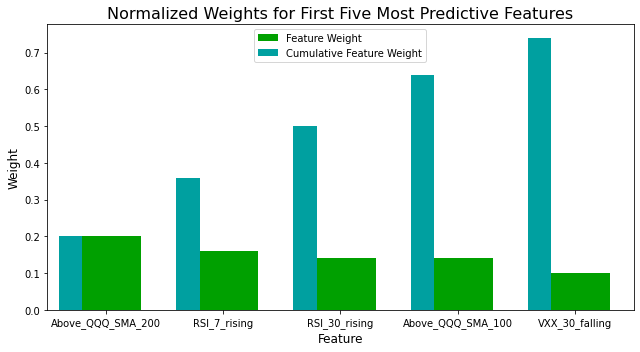

In [169]:
#Extract feature importance
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [170]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7075
F-score on testing data: 0.7552

Final Model trained on reduced data
------
Accuracy on testing data: 0.6974
F-score on testing data: 0.7423
